## BiLSTM-CRF model for Named Entity Recognition

### Installing keras contrib library to introduce CRF layer

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /private/var/folders/fk/czyq5vyj5hq3k3g6mjkj2xkh0000gn/T/pip-req-build-eisl_46o
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /private/var/folders/fk/czyq5vyj5hq3k3g6mjkj2xkh0000gn/T/pip-req-build-eisl_46o
  Stored in directory: /private/var/folders/fk/czyq5vyj5hq3k3g6mjkj2xkh0000gn/T/pip-ephem-wheel-cache-wgok9014/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


### Import the necessary libraries

In [4]:
import numpy as np
import pandas as pd

### Read the dataset

In [5]:
data = pd.read_csv("MedicalLetters1-BiLSTM-CRF-cleaned.csv", encoding="unicode_escape", error_bad_lines=False)

In [6]:
data

,Unnamed: 0,Sentence_id,Word,Tag
0,NaN,1.0,NUBEQAâÂ®,O
1,NaN,1.0,â(,O
2,NaN,1.0,darolutamide,Drug
3,NaN,1.0,),O
4,NaN,1.0,Pharmacokinetics,Pharmacokinetics
5,NaN,1.0,Summary:,O
6,NaN,1.0,â,O
7,NaN,1.0,Nubeqa,Drug
8,NaN,1.0,(,O
9,NaN,1.0,darolutamide,Drug


### Include only the wanted columns

In [7]:
data = data[['Sentence_id','Word','Tag']]
data.head()

,Sentence_id,Word,Tag
0,1.0,NUBEQAâÂ®,O
1,1.0,â(,O
2,1.0,darolutamide,Drug
3,1.0,),O
4,1.0,Pharmacokinetics,Pharmacokinetics


### Get all Sentences

In [8]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
print(sentences[1:3])

[[('â\x97\x8f', 'O'), ('Pharmacokinetics', 'Pharmacokinetics'), ('of', 'O'), ('darolutamide', 'Drug'), ('were', 'O'), ('determine', 'O'), ('as', 'O'), ('a', 'O'), ('part', 'O'), ('of', 'O'), ('the', 'O'), ('phase1-2', 'O'), ('study,', 'O'), ('which', 'O'), ('determined', 'O'), ('dose', 'O'), ('escalation,', 'O'), ('dose', 'O'), ('expansion,', 'O'), ('and', 'O'), ('long', 'O'), ('term', 'O'), ('follow-up.â\x80\x8b1', 'O')], [('o', 'O'), ('Pharmacokinetics', 'Pharmacokinetics'), ('were', 'O'), ('determined', 'O'), ('in', 'O'), ('patients', 'O'), ('receiving', 'O'), ('200', 'Dosage'), ('mg/day', 'Dosage'), ('(n=3),', 'O'), ('400', 'Dosage'), ('mg/day', 'Dosage'), ('(n=7),', 'O'), ('600', 'Dosage'), ('mg/day', 'Dosage'), ('(n=3)', 'O'), ('1000', 'Dosage'), ('mg/day', 'Dosage'), ('(n=3),', 'O'), ('1400', 'Dosage'), ('mg/day', 'Dosage'), ('(n=3),', 'O'), ('1800', 'Dosage'), ('mg/day', 'Dosage'), ('(n=3)', 'O'), ('with', 'O'), ('food', 'Food Interaction'), ('.', 'O')]]


In [10]:
from math import nan

words = list(set(data["Word"].values))
n_words = len(words)

tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

In [11]:
tags

['Duration',
 'Strength',
 'O',
 'Condition',
 'Tumor Markers',
 'Dosage',
 'Disease',
 'Drug',
 'Pharmacokinetics',
 'Adverse Event',
 'Food Interaction',
 'Form']

### Converting words, tags into IDs

In [12]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

### Importing Keras and Scikit-learn libraries

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### Finding maximum length of all input sentences

In [14]:
maxlen = max([len(s) for s in sentences])
maxlen

51

### Padding all input Sequences **X** to same maxlen input length

In [15]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

### Padding labels to same maxlen input length

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

### Split the dataset into train and testing data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Import the Keras Layers (Embedding, LSTM, CRF and so on)

In [18]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

### Specify the input
The input layer takes a shape parameter that is a tuple that indicates the dimensionality of the input data.

In [19]:
input = Input(shape=(51,))
word_embedding_size = 150

### Create the Embedding Layer
It takes three parameters :
- **input_dim** : Size of the vocabulary in the text data i.e; n_words+1
- **output_dim** : Dimensionality of the embeddings
- **input_length** : length of input_sequence i.e; length of the longest sentence

In [20]:
# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=51)(input)

### Create Bidirectional LSTM layers
It takes five parameters :
- **units** : Dimensionality of the output space
- **return_sequences** : If return_sequence = True, it returns the full sequence of output else, it return the last output in the output sequence.
- **dropout** : Fraction of the units to drop for the linear transformation of the inputs. It lies between 0 and 1.
- **recurrent_dropout** : Fraction of the units to drop for the linear transformation of the recurrent state. It lies between 0 and 1.
- **kernel_initializer** : Initializer for the kernel weights matrix, used for the linear transformation of the inputs.

In [21]:
# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

### TimeDistributed Layer
It is a wrapper that allow us to apply one layer to every element of our sequence independently. It is used in sequence classification to keep one-to-one relations on input and output.

In [23]:
model = TimeDistributed(Dense(n_tags, activation="relu"))(model) 

### CRF Layer

In [24]:
crf = CRF(n_tags)

### Create the Model

In [25]:
out = crf(model)
model = Model(input, out)

In [26]:
#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

In [27]:
# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/subashgandyer/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/subashgandyer/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 51)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 51, 150)           57600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 51, 300)           361200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 300)           721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 51, 12)            3612      
_________________________________________________________________
crf_1 (CRF)                  (None, 51, 12)            324       
Total params: 1,143,936
Trainable params: 1,143,936
Non-trainable params: 0
_________________________________________________________________


### Import libraries to facilitate Model Checkpointing

In [29]:
import keras
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

### Saving the best model only when validation accuracy is improved from previous epoch

In [30]:
filepath="nubeqa-ner-bilstm-crf-model-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [41]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 100 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"nubeqa-ner-bilstm-crf-model-{epoch}.hdf5")

### Fit the best model

In [42]:
saver = CustomSaver()
history = model.fit(X, np.array(y), batch_size=256, epochs=1000, validation_split=0.2, verbose=1, callbacks=[saver])


Train on 44 samples, validate on 12 samples
Epoch 1/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.2694 - crf_viterbi_accuracy: 0.9332 - acc: 0.0053 - val_loss: 0.2660 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch 2/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.2632 - crf_viterbi_accuracy: 0.9332 - acc: 0.0053 - val_loss: 0.2630 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch 3/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.2598 - crf_viterbi_accuracy: 0.9332 - acc: 0.0053 - val_loss: 0.2592 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch 4/1000
44/44 [==============================] - 0s 11ms/step - loss: 0.2617 - crf_viterbi_accuracy: 0.9332 - acc: 0.0053 - val_loss: 0.2558 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch 5/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.2591 - crf_viterbi_accuracy: 0.9332 - acc: 0.0053 - val_loss: 0.2529 - val_crf_viterbi_

Epoch 42/1000
44/44 [==============================] - 0s 7ms/step - loss: 0.2184 - crf_viterbi_accuracy: 0.9336 - acc: 0.0053 - val_loss: 0.2292 - val_crf_viterbi_accuracy: 0.9493 - val_acc: 0.9493
Epoch 43/1000
44/44 [==============================] - 0s 7ms/step - loss: 0.2165 - crf_viterbi_accuracy: 0.9332 - acc: 0.0053 - val_loss: 0.2295 - val_crf_viterbi_accuracy: 0.9493 - val_acc: 0.9493
Epoch 44/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.2164 - crf_viterbi_accuracy: 0.9354 - acc: 0.0053 - val_loss: 0.2317 - val_crf_viterbi_accuracy: 0.9493 - val_acc: 0.9493
Epoch 45/1000
44/44 [==============================] - 0s 7ms/step - loss: 0.2116 - crf_viterbi_accuracy: 0.9345 - acc: 0.0053 - val_loss: 0.2347 - val_crf_viterbi_accuracy: 0.9477 - val_acc: 0.9477
Epoch 46/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.2161 - crf_viterbi_accuracy: 0.9336 - acc: 0.0053 - val_loss: 0.2358 - val_crf_viterbi_accuracy: 0.9477 - val_acc: 0.9477
Epoch

Epoch 84/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.1548 - crf_viterbi_accuracy: 0.9447 - acc: 0.0053 - val_loss: 0.1830 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch 85/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.1534 - crf_viterbi_accuracy: 0.9398 - acc: 0.0053 - val_loss: 0.1814 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch 86/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.1584 - crf_viterbi_accuracy: 0.9452 - acc: 0.0053 - val_loss: 0.1806 - val_crf_viterbi_accuracy: 0.9493 - val_acc: 0.9493
Epoch 87/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.1483 - crf_viterbi_accuracy: 0.9492 - acc: 0.0053 - val_loss: 0.1811 - val_crf_viterbi_accuracy: 0.9493 - val_acc: 0.9493
Epoch 88/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.1504 - crf_viterbi_accuracy: 0.9461 - acc: 0.0053 - val_loss: 0.1823 - val_crf_viterbi_accuracy: 0.9510 - val_acc: 0.9510
Epoch

44/44 [==============================] - 0s 9ms/step - loss: 0.0861 - crf_viterbi_accuracy: 0.9697 - acc: 0.0053 - val_loss: 0.1366 - val_crf_viterbi_accuracy: 0.9542 - val_acc: 0.9542
Epoch 126/1000
44/44 [==============================] - 0s 10ms/step - loss: 0.0823 - crf_viterbi_accuracy: 0.9710 - acc: 0.0053 - val_loss: 0.1363 - val_crf_viterbi_accuracy: 0.9559 - val_acc: 0.9559
Epoch 127/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0851 - crf_viterbi_accuracy: 0.9670 - acc: 0.0053 - val_loss: 0.1357 - val_crf_viterbi_accuracy: 0.9559 - val_acc: 0.9559
Epoch 128/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.0794 - crf_viterbi_accuracy: 0.9737 - acc: 0.0053 - val_loss: 0.1348 - val_crf_viterbi_accuracy: 0.9559 - val_acc: 0.9559
Epoch 129/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0873 - crf_viterbi_accuracy: 0.9710 - acc: 0.0053 - val_loss: 0.1333 - val_crf_viterbi_accuracy: 0.9559 - val_acc: 0.9559
Epoch 130/1000

44/44 [==============================] - 0s 8ms/step - loss: 0.0495 - crf_viterbi_accuracy: 0.9817 - acc: 0.0053 - val_loss: 0.1128 - val_crf_viterbi_accuracy: 0.9592 - val_acc: 0.9592
Epoch 167/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0496 - crf_viterbi_accuracy: 0.9813 - acc: 0.0053 - val_loss: 0.1121 - val_crf_viterbi_accuracy: 0.9608 - val_acc: 0.9608
Epoch 168/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.0477 - crf_viterbi_accuracy: 0.9808 - acc: 0.0053 - val_loss: 0.1114 - val_crf_viterbi_accuracy: 0.9608 - val_acc: 0.9608
Epoch 169/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0484 - crf_viterbi_accuracy: 0.9831 - acc: 0.0053 - val_loss: 0.1106 - val_crf_viterbi_accuracy: 0.9608 - val_acc: 0.9608
Epoch 170/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0466 - crf_viterbi_accuracy: 0.9831 - acc: 0.0053 - val_loss: 0.1100 - val_crf_viterbi_accuracy: 0.9624 - val_acc: 0.9624
Epoch 171/1000


44/44 [==============================] - 0s 8ms/step - loss: 0.0227 - crf_viterbi_accuracy: 0.9902 - acc: 0.0053 - val_loss: 0.0747 - val_crf_viterbi_accuracy: 0.9788 - val_acc: 0.9788
Epoch 208/1000
44/44 [==============================] - 0s 7ms/step - loss: 0.0233 - crf_viterbi_accuracy: 0.9938 - acc: 0.0053 - val_loss: 0.0738 - val_crf_viterbi_accuracy: 0.9788 - val_acc: 0.9788
Epoch 209/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0279 - crf_viterbi_accuracy: 0.9880 - acc: 0.0053 - val_loss: 0.0733 - val_crf_viterbi_accuracy: 0.9771 - val_acc: 0.9771
Epoch 210/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0206 - crf_viterbi_accuracy: 0.9929 - acc: 0.0053 - val_loss: 0.0725 - val_crf_viterbi_accuracy: 0.9771 - val_acc: 0.9771
Epoch 211/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0277 - crf_viterbi_accuracy: 0.9871 - acc: 0.0053 - val_loss: 0.0716 - val_crf_viterbi_accuracy: 0.9804 - val_acc: 0.9804
Epoch 212/1000


44/44 [==============================] - 0s 8ms/step - loss: 0.0077 - crf_viterbi_accuracy: 0.9960 - acc: 0.0053 - val_loss: 0.0711 - val_crf_viterbi_accuracy: 0.9690 - val_acc: 0.9690
Epoch 249/1000
44/44 [==============================] - 0s 7ms/step - loss: 0.0109 - crf_viterbi_accuracy: 0.9955 - acc: 0.0053 - val_loss: 0.0687 - val_crf_viterbi_accuracy: 0.9739 - val_acc: 0.9739
Epoch 250/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0082 - crf_viterbi_accuracy: 0.9960 - acc: 0.0053 - val_loss: 0.0671 - val_crf_viterbi_accuracy: 0.9755 - val_acc: 0.9755
Epoch 251/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.0135 - crf_viterbi_accuracy: 0.9920 - acc: 0.0053 - val_loss: 0.0658 - val_crf_viterbi_accuracy: 0.9755 - val_acc: 0.9755
Epoch 252/1000
44/44 [==============================] - 0s 8ms/step - loss: 0.0109 - crf_viterbi_accuracy: 0.9951 - acc: 0.0053 - val_loss: 0.0626 - val_crf_viterbi_accuracy: 0.9755 - val_acc: 0.9755
Epoch 253/1000


Epoch 289/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0024 - crf_viterbi_accuracy: 0.9987 - acc: 0.0053 - val_loss: 0.0454 - val_crf_viterbi_accuracy: 0.9755 - val_acc: 0.9755
Epoch 290/1000
44/44 [==============================] - 0s 7ms/step - loss: 6.0116e-04 - crf_viterbi_accuracy: 0.9964 - acc: 0.0053 - val_loss: 0.0455 - val_crf_viterbi_accuracy: 0.9739 - val_acc: 0.9739
Epoch 291/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0025 - crf_viterbi_accuracy: 0.9978 - acc: 0.0053 - val_loss: 0.0456 - val_crf_viterbi_accuracy: 0.9739 - val_acc: 0.9739
Epoch 292/1000
44/44 [==============================] - 0s 9ms/step - loss: 0.0036 - crf_viterbi_accuracy: 0.9955 - acc: 0.0053 - val_loss: 0.0461 - val_crf_viterbi_accuracy: 0.9739 - val_acc: 0.9739
Epoch 293/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0013 - crf_viterbi_accuracy: 0.9982 - acc: 0.0053 - val_loss: 0.0466 - val_crf_viterbi_accuracy: 0.9739 - val_acc:

Epoch 330/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0077 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0359 - val_crf_viterbi_accuracy: 0.9820 - val_acc: 0.9820
Epoch 331/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0064 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0354 - val_crf_viterbi_accuracy: 0.9820 - val_acc: 0.9820
Epoch 332/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0051 - crf_viterbi_accuracy: 0.9991 - acc: 0.0053 - val_loss: 0.0352 - val_crf_viterbi_accuracy: 0.9820 - val_acc: 0.9820
Epoch 333/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0076 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0348 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 334/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0072 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0342 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.

Epoch 371/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0082 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0299 - val_crf_viterbi_accuracy: 0.9820 - val_acc: 0.9820
Epoch 372/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0086 - crf_viterbi_accuracy: 0.9991 - acc: 0.0053 - val_loss: 0.0295 - val_crf_viterbi_accuracy: 0.9820 - val_acc: 0.9820
Epoch 373/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0095 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0290 - val_crf_viterbi_accuracy: 0.9820 - val_acc: 0.9820
Epoch 374/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0091 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0285 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 375/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0092 - crf_viterbi_accuracy: 0.9991 - acc: 0.0053 - val_loss: 0.0284 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.

Epoch 412/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0123 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0286 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 413/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0133 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0284 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 414/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0111 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0282 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 415/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0133 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0279 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 416/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0128 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0277 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.

Epoch 453/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0144 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0263 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 454/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0143 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0264 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 455/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0142 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0264 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 456/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0138 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0264 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 457/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0145 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0263 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.

Epoch 494/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0154 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0261 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 495/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0156 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0262 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 496/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0154 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0262 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 497/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0151 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0260 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 498/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0153 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0257 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.

Epoch 535/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0162 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0251 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 536/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0162 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0252 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 537/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0161 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0253 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 538/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0159 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0253 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 539/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0164 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0253 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0

Epoch 576/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0174 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0215 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 577/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0168 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0218 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 578/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0166 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0219 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 579/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0165 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0221 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 580/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0173 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0224 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.

Epoch 617/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0173 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0197 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 618/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0177 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0196 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 619/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0172 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0194 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 620/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0180 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0191 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 621/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0176 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0189 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0

Epoch 658/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0183 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0165 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 659/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0184 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0162 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 660/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0178 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0162 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 661/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0187 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0162 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 662/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0186 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0162 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.

Epoch 699/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0190 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0176 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 700/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0192 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0173 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 701/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0193 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0171 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 702/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0191 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0168 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 703/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0194 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0165 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.

Epoch 740/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0197 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0185 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 741/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0197 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0183 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 742/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0195 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0180 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 743/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0198 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0176 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 744/1000
44/44 [==============================] - 0s 11ms/step - loss: -0.0197 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0174 - val_crf_viterbi_accuracy: 0.9853 - val_acc

Epoch 781/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0201 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0187 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 782/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0201 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0185 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 783/1000
44/44 [==============================] - 0s 7ms/step - loss: -0.0200 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0183 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 784/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0203 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0180 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 785/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0203 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0178 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.

Epoch 822/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0203 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0163 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 823/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0208 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0164 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 824/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0206 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0166 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 825/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0208 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0167 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 826/1000
44/44 [==============================] - 0s 11ms/step - loss: -0.0209 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0169 - val_crf_viterbi_accuracy: 0.9837 - val_acc:

Epoch 863/1000
44/44 [==============================] - 1s 13ms/step - loss: -0.0214 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0120 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.9886
Epoch 864/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0212 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0120 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.9886
Epoch 865/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0213 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0120 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 866/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0214 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0120 - val_crf_viterbi_accuracy: 0.9869 - val_acc: 0.9869
Epoch 867/1000
44/44 [==============================] - 0s 10ms/step - loss: -0.0214 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0120 - val_crf_viterbi_accuracy: 0.9869 - val_acc:

Epoch 904/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0218 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0149 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 905/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0215 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0146 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 906/1000
44/44 [==============================] - 1s 13ms/step - loss: -0.0212 - crf_viterbi_accuracy: 0.9996 - acc: 0.0053 - val_loss: 0.0146 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 907/1000
44/44 [==============================] - 0s 11ms/step - loss: -0.0219 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0145 - val_crf_viterbi_accuracy: 0.9837 - val_acc: 0.9837
Epoch 908/1000
44/44 [==============================] - 1s 13ms/step - loss: -0.0219 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0145 - val_crf_viterbi_accuracy: 0.9837 - val_acc:

Epoch 945/1000
44/44 [==============================] - 0s 8ms/step - loss: -0.0223 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0109 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 946/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0223 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0107 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 947/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0223 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0107 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 948/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0223 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0106 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.9853
Epoch 949/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0222 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0107 - val_crf_viterbi_accuracy: 0.9853 - val_acc: 0.

Epoch 986/1000
44/44 [==============================] - 0s 11ms/step - loss: -0.0227 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0098 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.9886
Epoch 987/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0226 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0097 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.9886
Epoch 988/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0227 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0097 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.9886
Epoch 989/1000
44/44 [==============================] - 0s 11ms/step - loss: -0.0226 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0096 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 0.9886
Epoch 990/1000
44/44 [==============================] - 0s 9ms/step - loss: -0.0227 - crf_viterbi_accuracy: 1.0000 - acc: 0.0053 - val_loss: 0.0096 - val_crf_viterbi_accuracy: 0.9886 - val_acc: 

### Plot the learnings

In [43]:
plt.style.use('ggplot')

In [44]:
def plot_history(history):
    accuracy = history.history['crf_viterbi_accuracy']
    val_accuracy = history.history['val_crf_viterbi_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

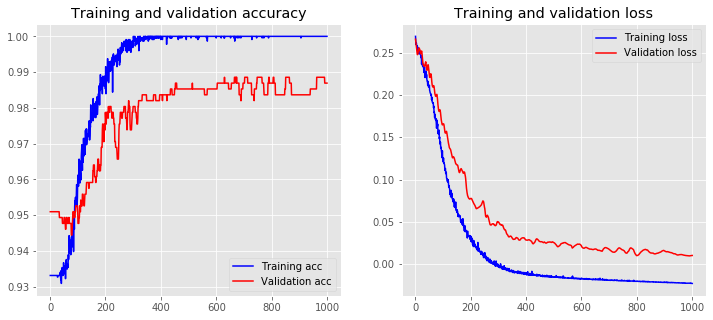

In [45]:
plot_history(history)

### Can we improve and how???

In [ ]:
1. Embedding
2. GridSearch on Hyperparameters
3. Architectural Change (Transformers)
4. 